### Colab Notebook Configuration 
If running in a Colab Notebook, these next few cells get the local environment configured. 

In [0]:
%%bash
apt-get install openjdk-8-jdk-headless -qq > /dev/null
wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
tar -xzf spark-2.4.5-bin-hadoop2.7.tgz
pip install pyspark findspark

In [0]:
%%bash
apt-get install openjdk-8-jdk-headless -qq > /dev/null
update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

In [0]:
import os
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PYSPARK_SUBMIT_ARGS"] ="--master local[2] pyspark-shell"

# Find Spark so that we can access session within our notebook
import findspark
findspark.init()

# Start SparkSession on all available cores
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
! pip install wget
import wget

# Download complaints data 
wget.download('https://macs-30123-final-proj-tyagie.s3.amazonaws.com/complaints.parquet', 'complaints.parquet')

In [0]:
DATA = 'complaints.parquet'

### EMR Cluster Configuration
If running on an EMR cluster, the PySpark configuration is already set up, but I have to install a few packages into the environment.  

In [0]:
# DATA = 's3://macs-30123-final-proj-tyagie/complaints.parquet'

In [0]:
# sc.install_pypi_package("seaborn")
# sc.install_pypi_package("pandas")

### Load Data
I first load the full CFPB Consumer Complaints Database. The original data is available from the [CFPB website](https://www.consumerfinance.gov/data-research/consumer-complaints/) under the Download the Data section. In the previous script `01_download-and-store.py`, I download this data in CSV format, then convert it to Parquet format and store it in an S3 bucket. 

In [8]:
from pyspark.sql.types import *

# Specify schema 
schema = StructType([
    StructField("date_received", StringType(), True),
    StructField("product", StringType(), True),
    StructField("sub-product", StringType(), True), 
    StructField("issue", StringType(), True),
    StructField("sub-issue", StringType(), True),
    StructField("consumer_complaint_narrative", StringType(), True), 
    StructField("company_public_response", StringType(), True),
    StructField("company", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip_code", StringType(), True), 
    StructField("tags", StringType(), True),
    StructField("consumer_consent_provided?", StringType(), True),
    StructField("submitted_via", StringType(), True), 
    StructField("date_sent_to_company", StringType(), True),
    StructField("company_response_to_consumer", StringType(), True),
    StructField("timely_response?", StringType(), True),
    StructField("consumer_disputed?", StringType(), True), 
    StructField("complaint_id", StringType(), True),
])

# Load data 
data = spark.read.parquet(DATA)

print('Total Rows: %d' % data.count())
data.printSchema()

Total Rows: 1607615
root
 |-- date_received: string (nullable = true)
 |-- product: string (nullable = true)
 |-- sub-product: string (nullable = true)
 |-- issue: string (nullable = true)
 |-- sub-issue: string (nullable = true)
 |-- consumer_complaint_narrative: string (nullable = true)
 |-- company_public_response: string (nullable = true)
 |-- company: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- consumer_consent_provided?: string (nullable = true)
 |-- submitted_via: string (nullable = true)
 |-- date_sent_to_company: string (nullable = true)
 |-- company_response_to_consumer: string (nullable = true)
 |-- timely_response?: string (nullable = true)
 |-- consumer_disputed?: string (nullable = true)
 |-- complaint_id: long (nullable = true)



### Explore Data
Next, I perform basic exploratory analysis. Specifically, I produce several visualizations showing the distributions of the key variables of interest in this dataset. 

In [0]:
import seaborn as sns 
import matplotlib.pyplot as plt

from pyspark.sql import functions as F

#### Complaints by Year 
The CFPB was [founded in 2011](https://www.consumerfinance.gov/about-us/the-bureau/creatingthebureau/), and there have clearly been a growing number of complaints filed every year since then. 

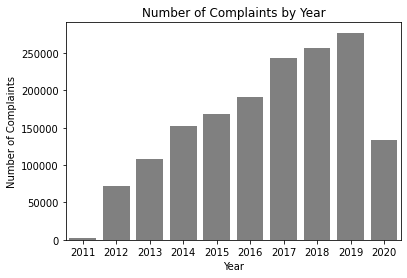

In [10]:
# Number of complaints by year
data = data.withColumn('year', data['date_received'].substr(1, 4)) 

complaints_by_year = (data.groupBy('year')
  .count()
  .sort('year').toPandas())

plt.close()
ax = sns.barplot(x='year', y='count', data=complaints_by_year, palette=['grey'])
ax.set_title('Number of Complaints by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Complaints'); 
# %matplot plt

#### Complaints by Day 
Plotting the number of complaints by day also shows the slight upward trend in the aggregate number of complaints filed over time. This also shows clear spikes including the [2017 Equifax data breach](https://www.consumerfinance.gov/policy-compliance/enforcement/actions/equifax-inc/).   

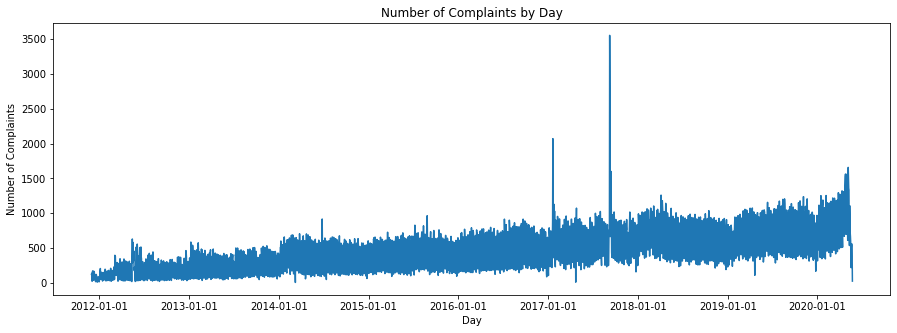

In [11]:
# Number of complaints by day 
complaints_by_day = (data.groupBy('date_received')
  .count() 
  .sort('date_received').toPandas())

plt.close()
plt.figure(figsize=(15,5))
ax = sns.lineplot(x='date_received', y='count', data=complaints_by_day, palette=['grey'])
ax.set_title('Number of Complaints by Day')
ax.set_xlabel('Day')
ax.set_ylabel('Number of Complaints') 

ax.set_xticks(['2012-01-01', 
               '2013-01-01', 
               '2014-01-01', 
               '2015-01-01', 
               '2016-01-01', 
               '2017-01-01', 
               '2018-01-01', 
               '2019-01-01',
               '2020-01-01']); 
# %matplot plt

### Complaints by Company Outcome 
The vast majority of complaints fall into the Closed with explanation category. 

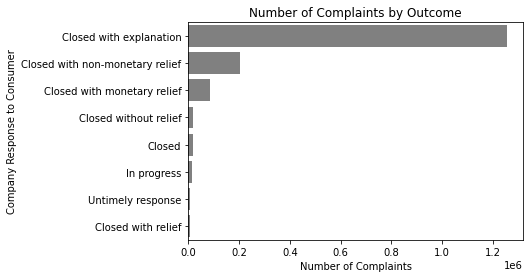

In [12]:
# Number of complaints by outcome 
complaints_by_year = (data.groupBy('company_response_to_consumer')
  .count()
  .sort('count', ascending=False).toPandas())

plt.close()
ax = sns.barplot(x='count', y='company_response_to_consumer', data=complaints_by_year, palette=['grey'])
ax.set_title('Number of Complaints by Outcome')
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Company Response to Consumer'); 
# %matplot plt

#### Complaints by Company
The majority of complaints are filed against the [three major credit reporting agencies](https://www.transunion.com/credit-reporting-agencies) in the U.S. – Equifax, Experian, and TransUnion. Most of the other companies receiving complaints involve banks (e.g. Bank of America, Wells Fargo, J.P. Morgan, etc.). There are over 5,000 distinct companies in the dataset. 

In [13]:
data.select(F.countDistinct('company')).show()

+-----------------------+
|count(DISTINCT company)|
+-----------------------+
|                   5629|
+-----------------------+



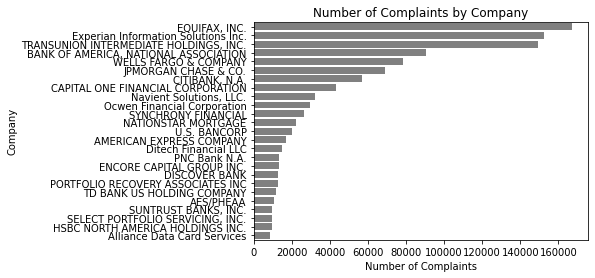

In [14]:
# Number of complaints by company 
complaints_by_company = (data.groupBy('company')
  .count()
  .sort('count', ascending=False).toPandas()[:25])

plt.close()
ax = sns.barplot(x='count', y='company', data=complaints_by_company, palette=['grey'])
ax.set_title('Number of Complaints by Company')
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Company'); 
# %matplot plt

### Complaints by Product
As reflected in the companies receiving the complaints above, most complaints involve credit reporting, mortgages, and debt collection. 

In [15]:
data.select(F.countDistinct('product')).show()

+-----------------------+
|count(DISTINCT product)|
+-----------------------+
|                     18|
+-----------------------+



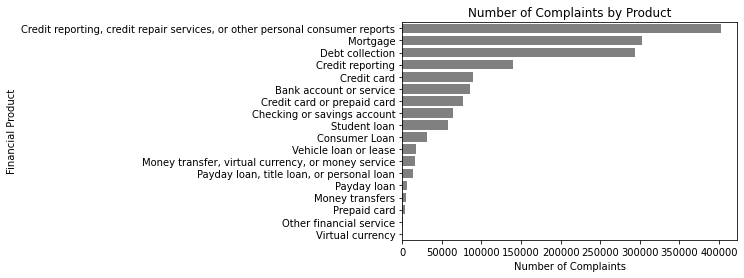

In [16]:
# Number of complaints by product 
complaints_by_product = (data.groupBy('product')
  .count()
  .sort('count', ascending=False).toPandas()[:25])

plt.close()
ax = sns.barplot(x='count', y='product', data=complaints_by_product, palette=['grey'])
ax.set_title('Number of Complaints by Product')
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Financial Product'); 
# %matplot plt

### Complaints by Issue
The most common issue reported in complaints involves incorrect information on a credit report. 

In [17]:
data.select(F.countDistinct('issue')).show()

+---------------------+
|count(DISTINCT issue)|
+---------------------+
|                  166|
+---------------------+



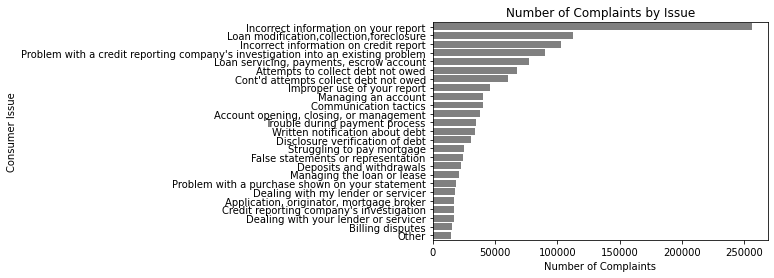

In [18]:
# Number of complaints by issue 
complaints_by_product = (data.groupBy('issue')
  .count()
  .sort('count', ascending=False).toPandas()[:25])

plt.close()
ax = sns.barplot(x='count', y='issue', data=complaints_by_product, palette=['grey'])
ax.set_title('Number of Complaints by Issue')
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Consumer Issue'); 
# %matplot plt